In [1]:
import sys
sys.path.append("C:/MYLOCALFILES/YOLO/models/research/")
sys.path.append("C:/MYLOCALFILES/YOLO/models/research/object_detection")

In [2]:
import numpy as np
import os
import six.moves.urllib as urllib
import tarfile
import tensorflow as tf
import zipfile
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from object_detection.utils import ops as utils_ops
%matplotlib inline

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

<h3>Object detection imports</h3>

In [3]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

c:\users\mjbol\anaconda3\envs\pabase\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<h3>Download Pretrained Models</h3>

In [4]:
#base path where we will save our models
PATH_TO_OBJ_DETECTION = 'C:/MYLOCALFILES/yolo/models/research/object_detection'

# Specify Model To Download. Obtain the model name from the object detection model zoo.
MODEL_NAME = 'ssd_inception_v2_coco_2017_11_17'
#MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_coco_2018_01_28'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

In [ ]:
DESTINATION_MODEL_TAR_PATH = PATH_TO_OBJ_DETECTION+'/data/'+MODEL_FILE
#opener = urllib.request.URLopener()
#opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, DESTINATION_MODEL_PATH)
tar_file = tarfile.open(DESTINATION_MODEL_TAR_PATH)
for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, PATH_TO_OBJ_DETECTION+'/data')

<h3>Load Pre-Trained Model</h3>

In [5]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

<h3>Load the Label Map</h3>

In [6]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = PATH_TO_OBJ_DETECTION+'/data/mscoco_label_map.pbtxt'
NUM_CLASSES=90

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

<h3>Image to Nupy Array</h3>

In [7]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

<Detection Code</h3>

<h3>Object Detection Method</h3>

In [25]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in ['num_detections', 'detection_boxes', 'detection_scores','detection_classes', 'detection_masks']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
                #END if tensor_name in
                if 'detection_masks' in tensor_dict:
                    # The following processing is only for single image
                    detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                    detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                    # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                    real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                    detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                    detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                        detection_masks, detection_boxes, image.shape[0], image.shape[1])
                    detection_masks_reframed = tf.cast(
                        tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                    # Follow the convention by adding back the batch dimension
                    tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
                #END IF DETECTION MASKS
            
            #END FOR KEY LOOP
                
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [27]:
from os import listdir
from os.path import isfile, join

TEST_IMAGES_BASE_PATH = "C:/MYLOCALFILES/yolo/Images/"
TEST_IMAGES_PATHS = [TEST_IMAGES_BASE_PATH+f for f in listdir(TEST_IMAGES_BASE_PATH) if isfile(join(TEST_IMAGES_BASE_PATH, f))]

In [34]:
def Run_Object_Detection_On_Images(images_path):
    IMAGE_SIZE = (12, 8)
    for image_path in images_path:
        image = Image.open(image_path)
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        image_np = load_image_into_numpy_array(image)

        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)

        # Actual detection.
        output_dict = run_inference_for_single_image(image_np, detection_graph)

        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          output_dict['detection_boxes'],
          output_dict['detection_classes'],
          output_dict['detection_scores'],
          category_index,
          instance_masks=output_dict.get('detection_masks'),
          use_normalized_coordinates=True,
          line_thickness=5)
        plt.figure(figsize=IMAGE_SIZE)
        plt.imshow(image_np)

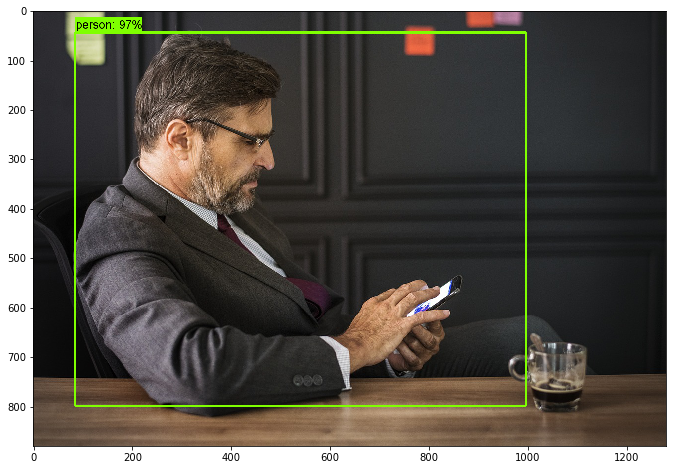

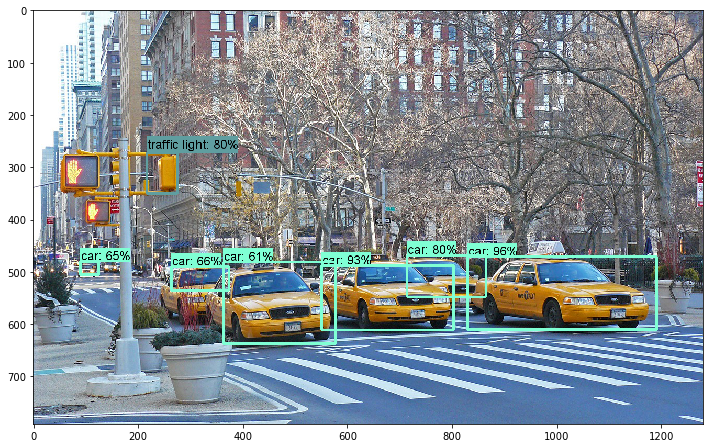

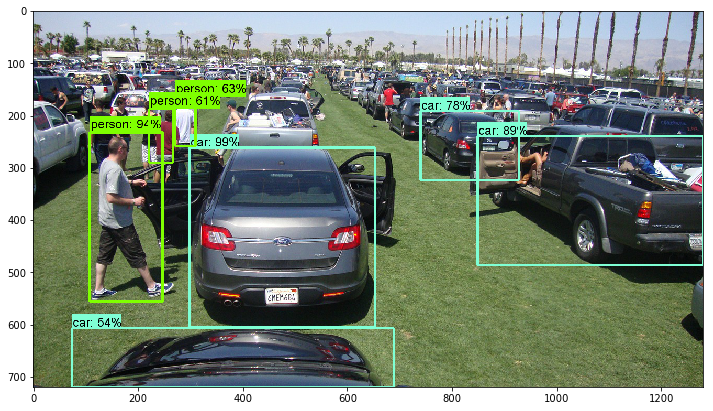

In [35]:
Run_Object_Detectio_On_Images(TEST_IMAGES_PATHS)